In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import copy

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

In [2]:
# various options in pandas
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

In [5]:
# Challenge 1
# Open up a new IPython notebook
# Download a few MTA turnstile data files
# Read them into a pandas dataframe (pd.read_csv()), format 
# the columns nicely, and display the first few rows.

def get_data(dates):
    url = "../01_Data/turnstile_{}.txt"
    dfs = []
    for date in dates:
        file_url = url.format(date)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs) 

dates = [180519, 180526, 180602]
mta_df = get_data(dates)

#Cleaning Columns
mta_df.rename(index=str, columns={"C/A": "CA"}, inplace = True)  #rename C/A because the slash might cause errors
mta_df.columns = [column.strip() for column in mta_df.columns]   #strip off random spaces after EXIT

In [6]:
# Challenge 1 - CON'T
#Since there are unique linenames for stations due to the order of the lines (ex: 456NRW = NRW456)
#This cleans the linenames and standardizes them to the same order and creates a dictionary 

linenames = set(mta_df["LINENAME"].tolist())  #create unique list of all linenames from dataset
linenames_dict = collections.defaultdict()

#create a dictionary of line names
for name in linenames:
    if len(name) == 1:         #if there is only one line, it must be unique
        linenames_dict[name]=name
    else:                      #this alphabetizes the indivudual lines within each station
        char = [name[0]]       #so that there are no unique combinations due to line order
        for i in name[1:]:
            char.append(i)
        char.sort()
        linenames_dict[name] = ''.join(char)

#Remap the LINENAME column using this dictionary
mta_df["LINENAME"] = mta_df["LINENAME"].map(linenames_dict) 

In [7]:
# Challenge 1 - CON'T
#Check if STATION NAME OCCUR MORE THAN ONCE
duplicate_df = mta_df.groupby(['STATION', 'LINENAME']).count()    #this isolates unique line/station combinations
duplicate_df = duplicate_df.reset_index()
duplicate_df = duplicate_df[["STATION","LINENAME"]]

#this counts how many station duplicates there are and makes a dictionary Station Name:Duplicates
stationcount_df = duplicate_df.groupby(['STATION']).count() 
stationcount_df = stationcount_df.reset_index()
stationcount_df = stationcount_df.set_index("STATION")
stationdict1 = stationcount_df.to_dict()
stationdict1 = stationdict1["LINENAME"]

duplicate_df["INSTANCES"] = duplicate_df["STATION"].map(stationdict1)  #Map instances to new column via station name

In [8]:
# Challenge 1 - CON'T
#build a dictionary of "Station - Linename" to updated Station Name
duplicate_df["UNIQUESTATION"] = duplicate_df["STATION"] + ' - ' + duplicate_df["LINENAME"]

def uniquename(row):                 #definition to check if a station name appears more than once, if it does, 
     if row["INSTANCES"] == 1:       #concatenate the station name with the line name
         return row["STATION"]
     else: return row["STATION"] + ' - ' + row["LINENAME"]

duplicate_df["STATION"] = duplicate_df.apply(uniquename, axis=1)

duplicate_df = duplicate_df.set_index("UNIQUESTATION")
duplicate_df = duplicate_df.drop(['LINENAME', 'INSTANCES'], axis=1)
stationdict = duplicate_df.to_dict()
stationdict = stationdict['STATION']   #USE THIS TO MAP UNIQUE STATION NAMES 

#Create unique key and map it to station to give stations unique names
mta_df["STATION"] = mta_df["STATION"] + ' - ' + mta_df["LINENAME"]
mta_df["STATION"] = mta_df["STATION"].map(stationdict) 

In [9]:
# Challenge 1 - CON'T
# Through inspecting the data, 42 ST-PORT AUTH, TIMES SQ-42 ST and 34 ST-PENN STA
# have unusual linename combinations that are inconsistent. This standardizes these three stations

station_dict = collections.defaultdict()
station_dict = dict(zip(mta_df["STATION"],mta_df["STATION"]))
station_dict['42 ST-PORT AUTH - 1237ACEGNRSW']='42 ST-PORT AUTH'
station_dict['42 ST-PORT AUTH - 1237ACENQRSW']='42 ST-PORT AUTH'
station_dict['TIMES SQ-42 ST - 1237ACENQRSW']='TIMES SQ-42 ST'
station_dict['TIMES SQ-42 ST - 1237ACENQRS']='TIMES SQ-42 ST'
station_dict['34 ST-PENN STA - ACE']="34 ST-PENN STA"
station_dict["34 ST-PENN STA - 123"]="34 ST-PENN STA"
station_dict["34 ST-PENN STA - 123ACE"]="34 ST-PENN STA"
mta_df["STATION"] = mta_df["STATION"].map(station_dict) 

mta_df.head(10)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/12/2018,00:00:00,REGULAR,6616743,2242108
1,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/12/2018,04:00:00,REGULAR,6616762,2242113
2,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/12/2018,08:00:00,REGULAR,6616781,2242144
3,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/12/2018,12:00:00,REGULAR,6616886,2242229
4,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/12/2018,16:00:00,REGULAR,6617105,2242278
5,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/12/2018,20:00:00,REGULAR,6617402,2242328
6,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/13/2018,00:00:00,REGULAR,6617539,2242342
7,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/13/2018,04:00:00,REGULAR,6617560,2242345
8,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/13/2018,08:00:00,REGULAR,6617575,2242362
9,A002,R051,02-00-00,59 ST - 456NQRW,456NQRW,BMT,05/13/2018,12:00:00,REGULAR,6617674,2242431


In [10]:
# Challenge 2

# Let's turn this into a time series.
# Create a new column that stores the date and time as a single pandas datetime object.
mta_df["DATETIME"] = pd.to_datetime(mta_df['DATE'] + ' ' + mta_df['TIME'] )

In [11]:
# Challenge 3

# These counts are for every n hours (What is n?). Also, there's something odd about these "counts", 
# what is it? Do they actually represent total entries for a time period, or something else? We want 
# total daily entries, create a new dataframe with one row per turnstile/day and a column that gives 
# total daily entries.

mta_df = (mta_df.groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False).ENTRIES.first())
mta_df["ENTRIES_END"] = (mta_df.groupby(["CA", "UNIT", "SCP", "STATION"])["ENTRIES"]
                                                       .transform(lambda grp: grp.shift(-1)))

#calcualte the total entries by subtracting subsequent days
mta_df["ENTRIES_TOT"] = mta_df["ENTRIES_END"] - mta_df["ENTRIES"]
mta_df.drop(["ENTRIES_END"],inplace=True,axis=1)
mta_df.dropna(inplace=True)   #remove the NA that results from the shift operation

# Modifying class code to clean negative values
def get_daily_counts(row, column):
    counter = row[column]
    if counter < 0:
        counter = -counter
    return counter

mta_df["ENTRIES_TOT"] = mta_df.apply(get_daily_counts, axis=1, column="ENTRIES_TOT")

# Modifying class code to clean negative values
def count_max(row, column, value):
    counter = row[column]
    if counter > value:
        counter = 0
    return counter

mta_df["ENTRIES_TOT"] = mta_df.apply(count_max, axis=1, column="ENTRIES_TOT",value=15000)

mta_df.head(10)

,CA,UNIT,SCP,STATION,DATE,ENTRIES,ENTRIES_TOT
0,A002,R051,02-00-00,59 ST - 456NQRW,05/12/2018,6616743,796.0
1,A002,R051,02-00-00,59 ST - 456NQRW,05/13/2018,6617539,577.0
2,A002,R051,02-00-00,59 ST - 456NQRW,05/14/2018,6618116,1429.0
3,A002,R051,02-00-00,59 ST - 456NQRW,05/15/2018,6619545,1390.0
4,A002,R051,02-00-00,59 ST - 456NQRW,05/16/2018,6620935,1486.0
5,A002,R051,02-00-00,59 ST - 456NQRW,05/17/2018,6622421,1477.0
6,A002,R051,02-00-00,59 ST - 456NQRW,05/18/2018,6623898,1572.0
7,A002,R051,02-00-00,59 ST - 456NQRW,05/19/2018,6625470,660.0
8,A002,R051,02-00-00,59 ST - 456NQRW,05/20/2018,6626130,536.0
9,A002,R051,02-00-00,59 ST - 456NQRW,05/21/2018,6626666,1420.0


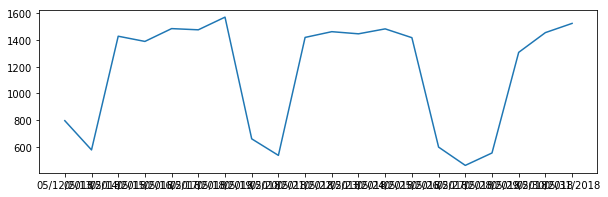

In [12]:
# Challenge 4
# We will plot the daily time series for a turnstile.

myturnstile = mta_df[(mta_df["CA"]=="A002") & (mta_df["SCP"]=="02-00-00") & (mta_df["STATION"]=='59 ST - 456NQRW')]
dates = myturnstile["DATE"]
counts = myturnstile["ENTRIES_TOT"]

plt.figure(figsize=(10,3))
plt.plot(dates,counts);

In [13]:
# Challenge 5

# So far we've been operating on a single turnstile level, let's combine turnstiles in the 
#same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that 
#have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT 
#and STATION columns, different values for the SCP column.

booth_area_df = mta_df.groupby(["CA", "UNIT", "STATION", "DATE"])[["ENTRIES_TOT"]].sum()
booth_area_df.head(10)

ENTRIES_TOT
CA   UNIT STATION         DATE                   
A002 R051 59 ST - 456NQRW 05/12/2018       8333.0
                          05/13/2018       6785.0
                          05/14/2018      13530.0
                          05/15/2018      13546.0
                          05/16/2018      13990.0
                          05/17/2018      14088.0
                          05/18/2018      13985.0
                          05/19/2018       6838.0
                          05/20/2018       5712.0
                          05/21/2018      13167.0

In [14]:
# Challenge 6

# Similarly, combine everything in each station, and come up with a time series of 
#[(date1, count1),(date2,count2),...] type of time series for each STATION, by adding 
#up all the turnstiles in a station.

station_df = mta_df.groupby(["STATION", "DATE"])[["ENTRIES_TOT"]].sum()
station_df = station_df.reset_index()
station_df["SERIES"] = list(zip(station_df["DATE"], station_df["ENTRIES_TOT"]))
station_df.drop(["DATE","ENTRIES_TOT"],axis=1,inplace=True)
station_df = station_df.groupby(["STATION"])["SERIES"].apply(list)
station_df

STATION
1 AV                   [(05/12/2018, 17985.0), (05/13/2018, 12964.0),...
103 ST - 1             [(05/12/2018, 9456.0), (05/13/2018, 7773.0), (...
103 ST - 6             [(05/12/2018, 7332.0), (05/13/2018, 5601.0), (...
103 ST - BC            [(05/12/2018, 2195.0), (05/13/2018, 1684.0), (...
103 ST-CORONA          [(05/12/2018, 13948.0), (05/13/2018, 10271.0),...
104 ST - A             [(05/12/2018, 880.0), (05/13/2018, 560.0), (05...
104 ST - JZ            [(05/12/2018, 1245.0), (05/13/2018, 856.0), (0...
110 ST                 [(05/12/2018, 7085.0), (05/13/2018, 5230.0), (...
111 ST - 7             [(05/12/2018, 8111.0), (05/13/2018, 6006.0), (...
111 ST - A             [(05/12/2018, 1137.0), (05/13/2018, 676.0), (0...
111 ST - J             [(05/12/2018, 1409.0), (05/13/2018, 1067.0), (...
116 ST - 23            [(05/12/2018, 7268.0), (05/13/2018, 6401.0), (...
                                             ...                        
WEST FARMS SQ          [(05/12/2018, 2983.0

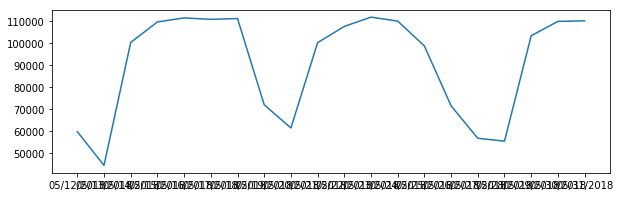

In [15]:
# Challenge 7 Plot the time series for a station.

date, counts = zip(*station_df["TIMES SQ-42 ST"])

plt.figure(figsize=(10,3))
plt.plot(dates,counts); 

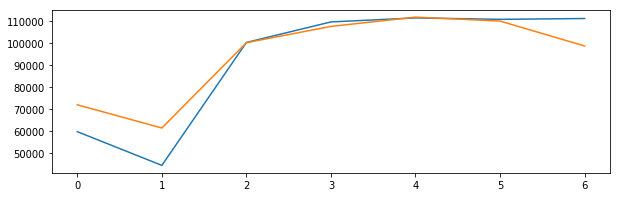

In [16]:
# Challenge 8

# Make one list of counts for one week for one station. Monday's count, Tuesday's 
# count, etc. so it's a list of 7 counts. Make the same list for another week, and 
# another week, and another week. plt.plot(week_count_list) for every week_count_list 
# you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.


station = station_df["TIMES SQ-42 ST"]
date, counts = zip(*station_df["TIMES SQ-42 ST"])

weeks = int(len(station)/7) #this is the number of weeks

weeklylist = []

for w in range(0,weeks):
    temp_list = []
    for d in range(1,8):  #for days 1-7 of a week
        temp_list.append(counts[w*7+d-1])   #w*7+d represents the week count
    weeklylist.append(temp_list)
    
    
plt.figure(figsize=(10,3))
for week in weeklylist:
    plt.plot(week); 

In [17]:
# Challenge 9

# Over multiple weeks, sum total ridership for each station and sort them, 
# so you can find out the stations with the highest traffic during the time 
# you investigate

top_stations = mta_df.groupby(["STATION"])["ENTRIES_TOT"].sum()
top_stations = top_stations.reset_index()
top_stations.sort_values("ENTRIES_TOT", ascending=0).head(10)

,STATION,ENTRIES_TOT
86,34 ST-PENN STA,2.780e+06
296,GRD CNTRL-42 ST,2.431e+06
84,34 ST-HERALD SQ,2.103e+06
26,14 ST-UNION SQ,1.820e+06
431,TIMES SQ-42 ST,1.814e+06
93,42 ST-PORT AUTH,1.797e+06
287,FULTON ST - 2345ACJZ,1.476e+06
114,59 ST COLUMBUS,1.264e+06
274,FLUSHING-MAIN,1.001e+06
220,CANAL ST - 6JNQRWZ,9.309e+05


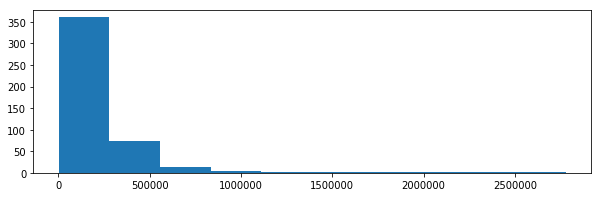

In [18]:
# Challenge 10

# Make a single list of these total ridership values and plot it with
# plt.hist(total_ridership_counts)

stations = list(top_stations["STATION"])
total_ridership_counts = list(top_stations["ENTRIES_TOT"])

plt.figure(figsize=(10,3))
plt.hist(total_ridership_counts, bins=10);